In [1]:
# get the model from github
!git clone https://github.com/AntonioSkara132/LangPathModel.git

Cloning into 'LangPathModel'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 606 (delta 14), reused 20 (delta 9), pack-reused 577 (from 1)
Receiving objects: 100% (606/606), 165.71 MiB | 24.23 MiB/s, done.
Resolving deltas: 100% (327/327), done.


### **Initialization**

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline
!apt-get -y update && apt-get -y install ffmpeg


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,724 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,740 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,999 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jam

###**Dataset Creation**

In [3]:
!git clone https://huggingface.co/datasets/Tonio123/CaptyShapes -b main

Cloning into 'CaptyShapes'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (12/12), 4.14 KiB | 2.07 MiB/s, done.


###**Data visualization**

tokenizer_config.json: 100% 48.0/48.0 [00:00<00:00, 304kB/s]
config.json: 100% 570/570 [00:00<00:00, 3.40MB/s]
vocab.txt: 100% 232k/232k [00:00<00:00, 9.80MB/s]
tokenizer.json: 100% 466k/466k [00:00<00:00, 6.50MB/s]


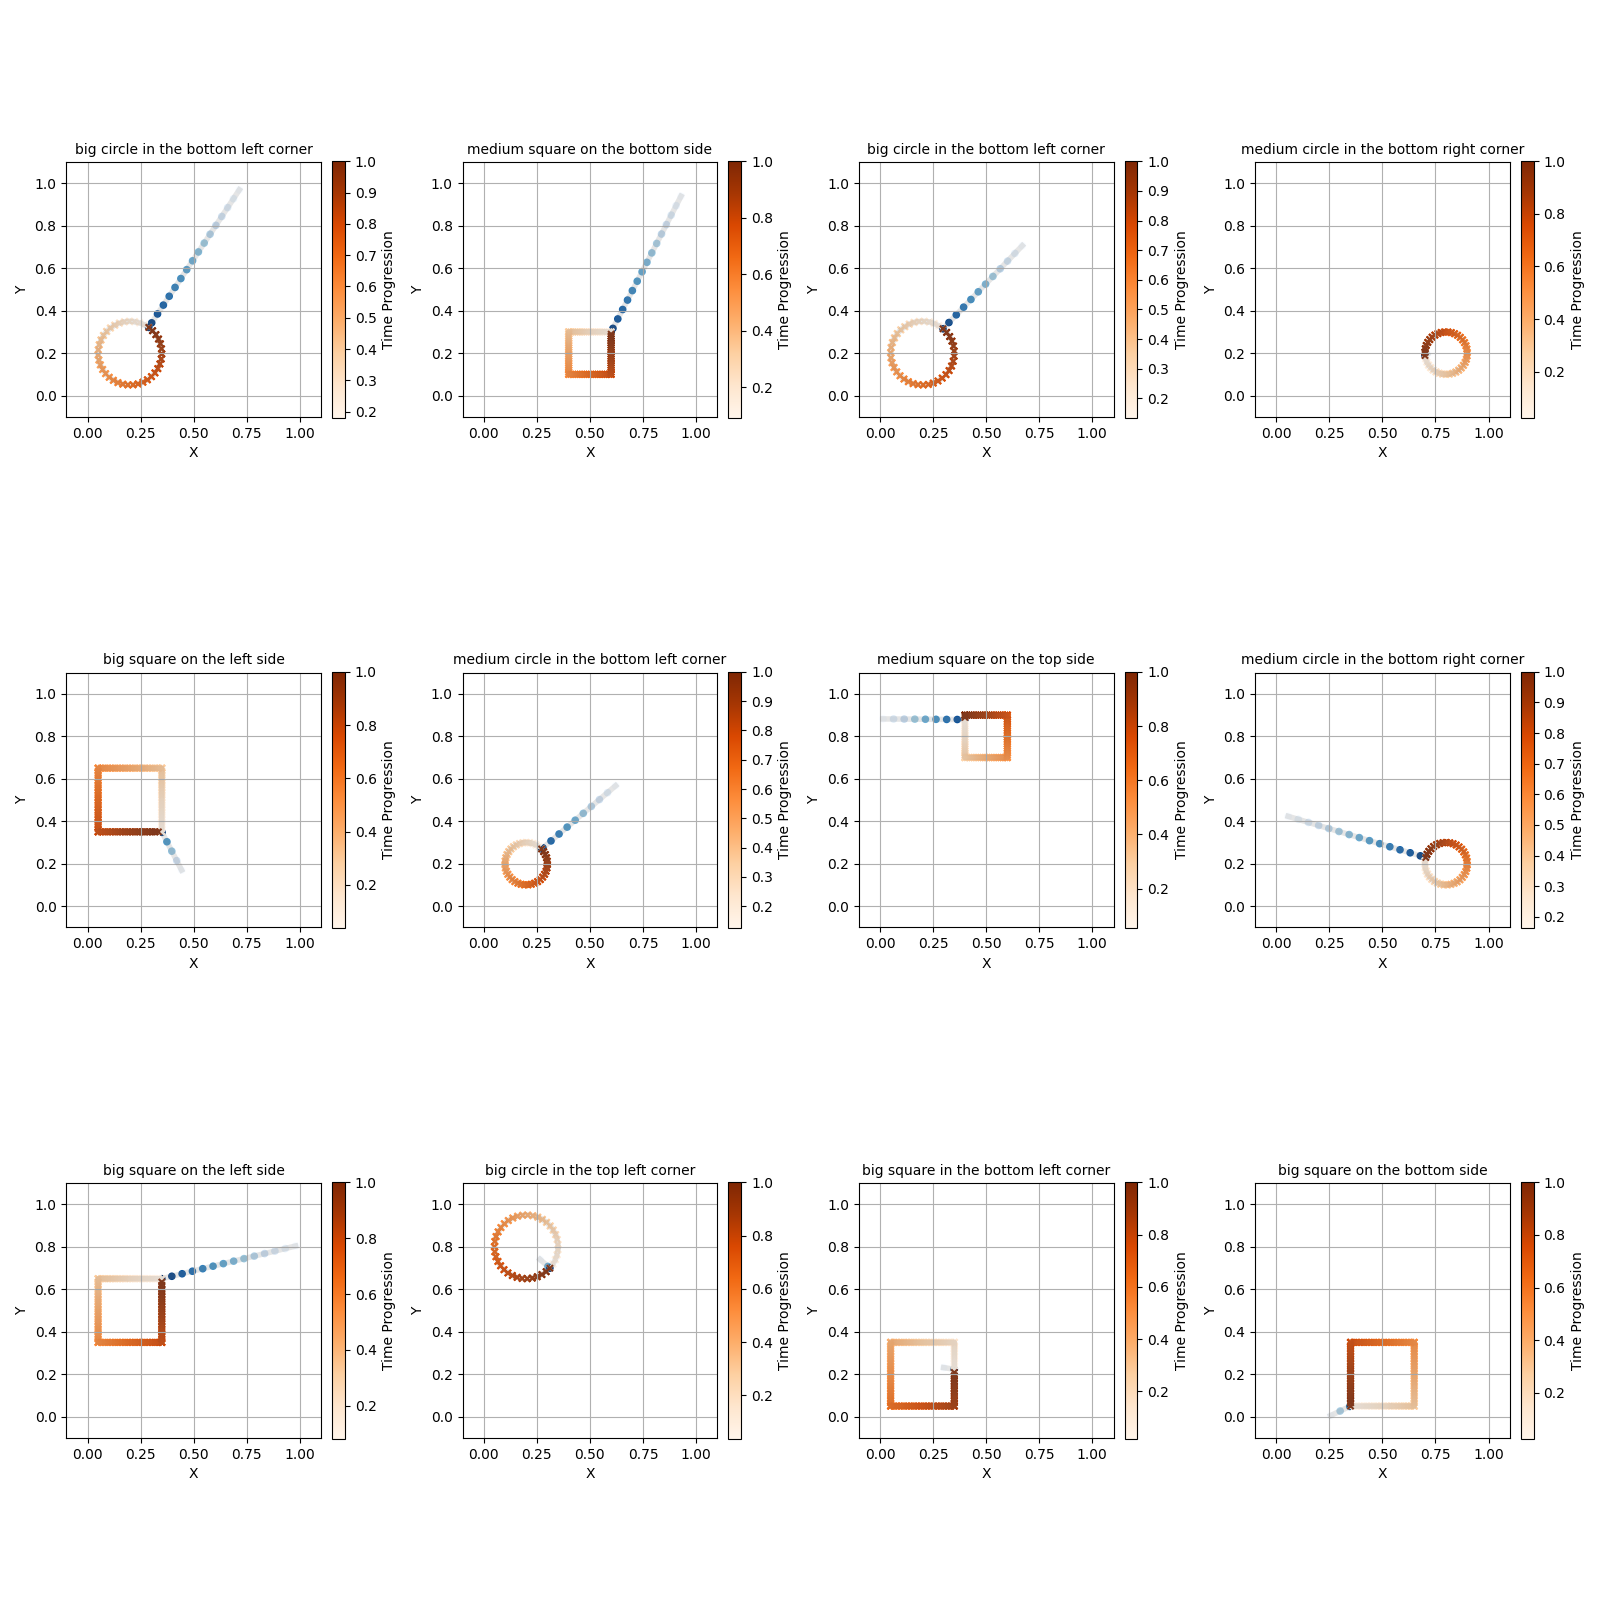

In [4]:
!python /content/LangPathModel/data/data_visualization.py /content/CaptyShapes/all_shapes.pt
display(Image("visualization.png"))

###**Training**

In [ ]:
!python LangPathModel/src/training.py \
  --niter 1 \
  --start_lr 0.001 \
  --lr_step 10 \
  --weight_decay 1e-5 \
  --d_model 64 \
  --num_heads 8 \
  --num_decoder_layers 2 \
  --dropout 0.2 \
  --gamma 0.1 \
  --batch_size 500 \
  --dataset_path /content/CaptyShapes/all_shapes.pt \
  --output_path /content/new_model.pth \
  --ckpt_path /content/LangPathModel/checkpoints
#for testing use small_dataset.pt instead of all shapes.pt

2025-06-03 16:30:16.896898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748968216.919064    3164 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748968216.925639    3164 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


###**Evaluate**

In [6]:
#doesnt work
!ls
!python LangPathModel/src/evaluate_model.py \
        --model_path /content/new_model.pth \
        --prompt "bottom circle" \



CaptyShapes  LangPathModel  sample_data  visualization.png
  File "/content/LangPathModel/src/evaluate_model.py", line 120
    plt.scatter(x, y, c=color, s=50, label=label)
TabError: inconsistent use of tabs and spaces in indentation


In [7]:
#temporary testing ground
import torch
import sys
sys.path.append('/content/drive/MyDrive')
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from LangPathModel.src.textEncoders import TextEncoder
from LangPathModel.src.nn import LangPathModel
from transformers import AutoTokenizer

d_model = 64
model = LangPathModel(d_model=d_model, num_heads_decoder=8, num_decoder_layers=2, dropout = 0.2)
model.eval()
# Step 2: Load the saved state dict
model.load_state_dict(torch.load('/content/LangPathModel/checkpoints/model_state_epoch_020.pth', map_location='cuda' if torch.cuda.is_available() else 'cpu'))

# Step 3: Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.positional_encoding = model.positional_encoding.to(device)  # This line was added

# Initialize tokenizer and encoder
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_encoder = TextEncoder(output_dim=d_model)

# Text and encoding
text = "medium circle in middle"
encoded = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

# **Instead of directly using text_encoder output, use encoded['input_ids'] and encoded['attention_mask']**
# txt = text_encoder(encoded['input_ids'], encoded['attention_mask'])
txt = encoded['input_ids'].to(device)
txt_mask = (encoded['attention_mask'] == 0).to(device)


path_mask = torch.Tensor([[1, 1]]).to(device)
print(path_mask.shape)

# Iniptialize starting point
start = torch.Tensor([[[0.1, 0.9, 0, 0]]]).to(device)  # (1, 1, 4)
#tgt = torch.empty([1, 1, 4]).to(device)  # (1, 1, 4)
tgt = start
# Store predictions
positions = [start[0, 0, :2].clone().cpu().numpy()]

# Loop to generate 200 predictions
for i in range(200):
    with torch.no_grad():
        prediction = model(
            text=txt,
            tgt=tgt,
            text_mask=txt_mask,
            path_mask=path_mask
        )  # Output shape: (1, seq_len+1, 4
    next_point = prediction[:, -1, :]  # Get the last predicted point
    #print(next_point)
    positions.append(next_point[0, :2].cpu().numpy())  # Save (x, y)

    # Append next_point to tgt for next prediction
    tgt = torch.cat([tgt, next_point.unsqueeze(1)], dim=1)
    path_mask = torch.cat([path_mask, torch.ones((1, 1)).to(device)], dim=1)
    print(path_mask.shape)
    #print(tgt[0, :, :
    if next_point[0, 3] > 0.5: break
    #print(next_point[0, 3])

# Convert predictions to numpy array
positions = np.array(positions)  # shape: (num_points, 2)
actions = tgt[0, :, 2].cpu().numpy()  # shape: (num_points,) - only 'a' values
#print(positions)
# Bin actions
binned_actions = (actions >= 0.5).astype(int)  # 0 if a < 0.5, 1 otherwise

# Plot
plt.figure(figsize=(8, 6))
for i in range(len(positions)):
    x, y = positions[i]
    if binned_actions[i] == 0:
        plt.scatter(x, y,color='blue', label='Action = 0' if i == 0 else "", s=50)
    else:
        plt.scatter(x, y, color='red', label='Action = 1' if i == 0 else "", s=50)

plt.title("Generated Path with Binned Actions (0=blue, 1=red)")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

plt.legend()
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

FileNotFoundError: [Errno 2] No such file or directory: '/content/LangPathModel/checkpoints/model_state_epoch_020.pth'

###**Add velocities and export it as csv**

In [ ]:
#to do
#vels = path2vels(path)
#path = [path, vels]
#save to csv